Generating plot from tsv file:  S8e_v14-6g_h31-6g.tsv
Generating plot from tsv file:  S8e_v27-7g_h31-6g.tsv
Generating plot from tsv file:  S8e_v34-0g_h31-6g.tsv
Generating plot from tsv file:  S8e_v5-9g_h31-6g.tsv


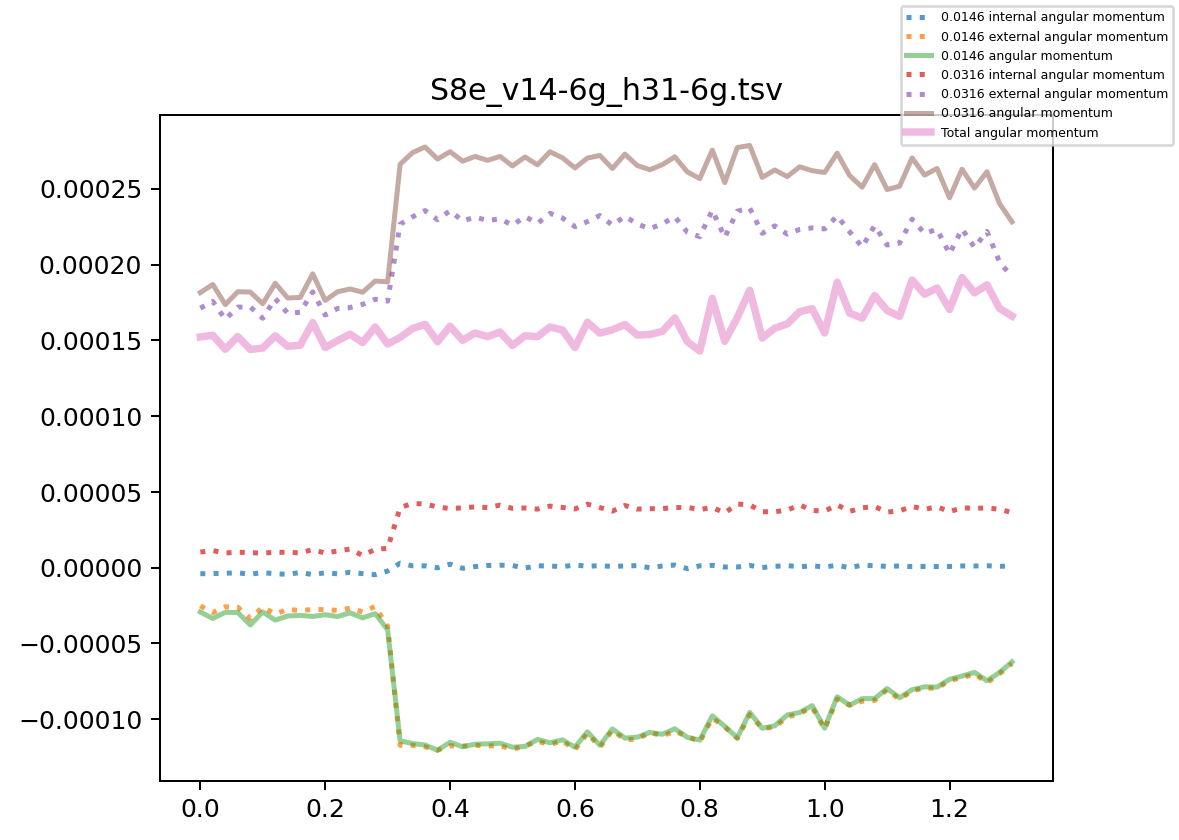

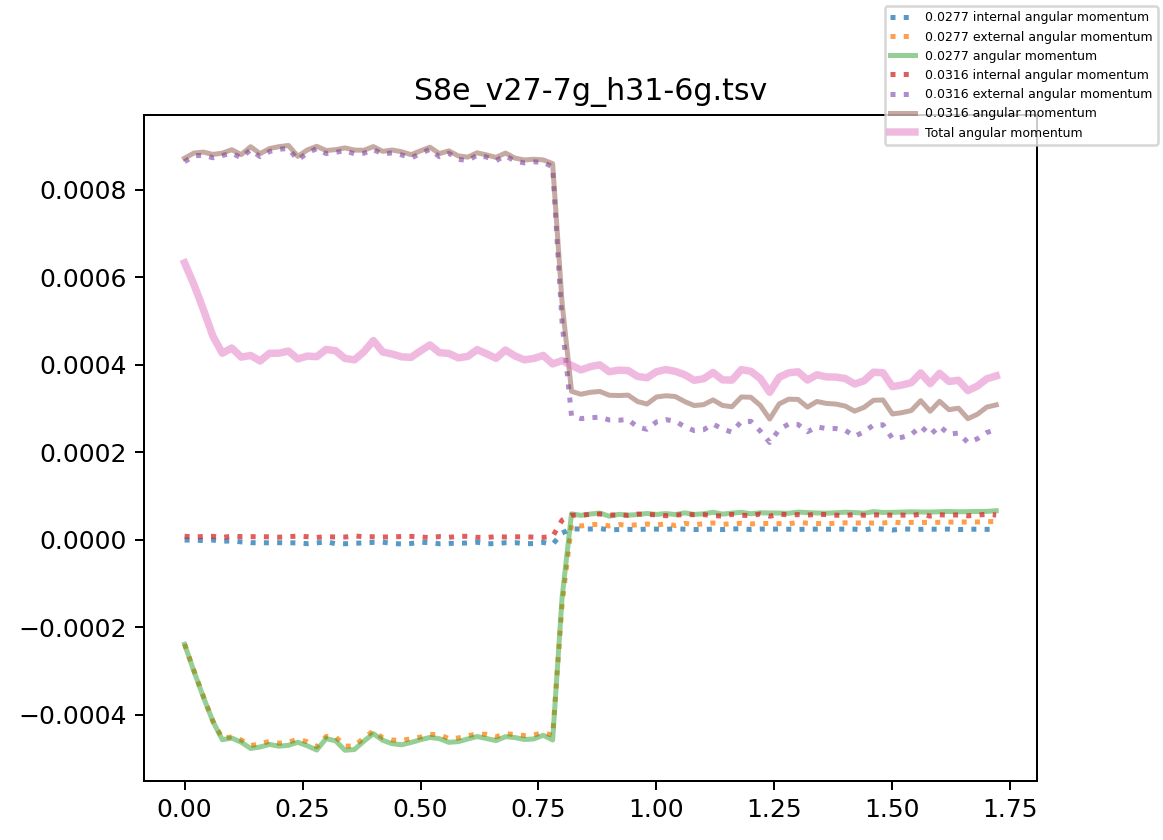

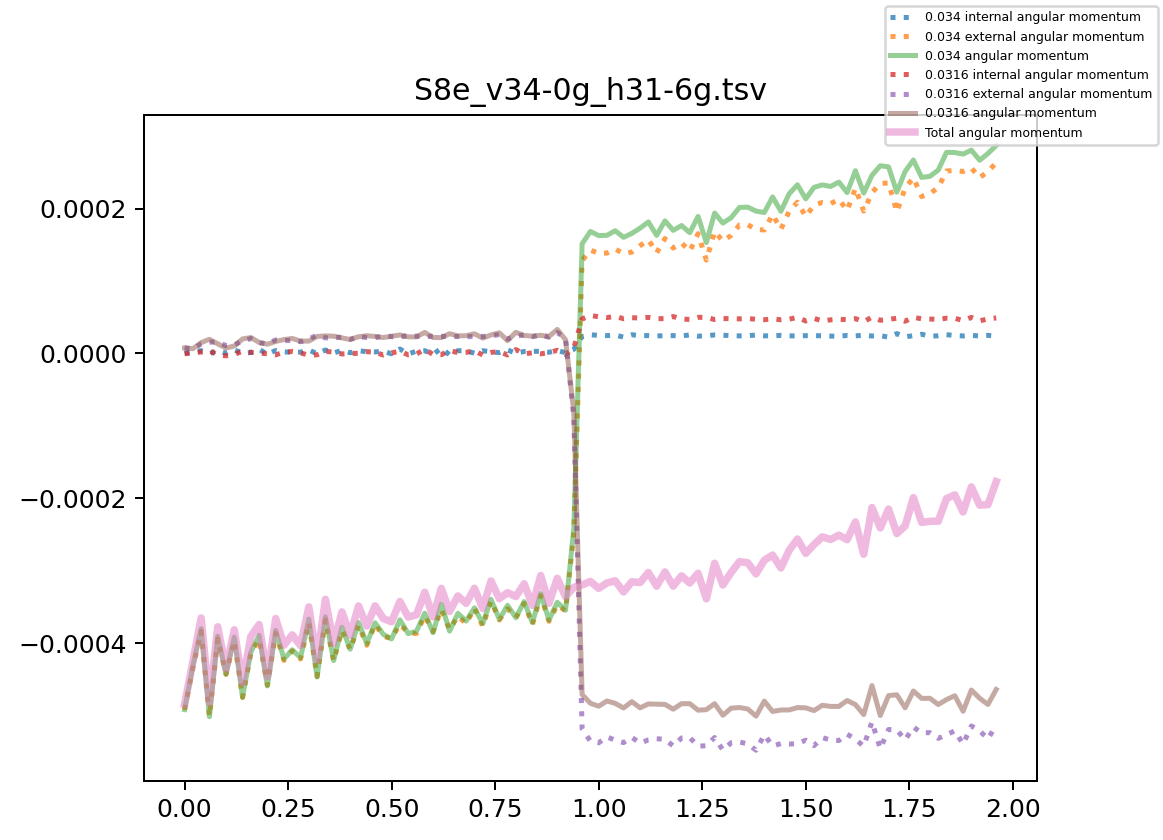

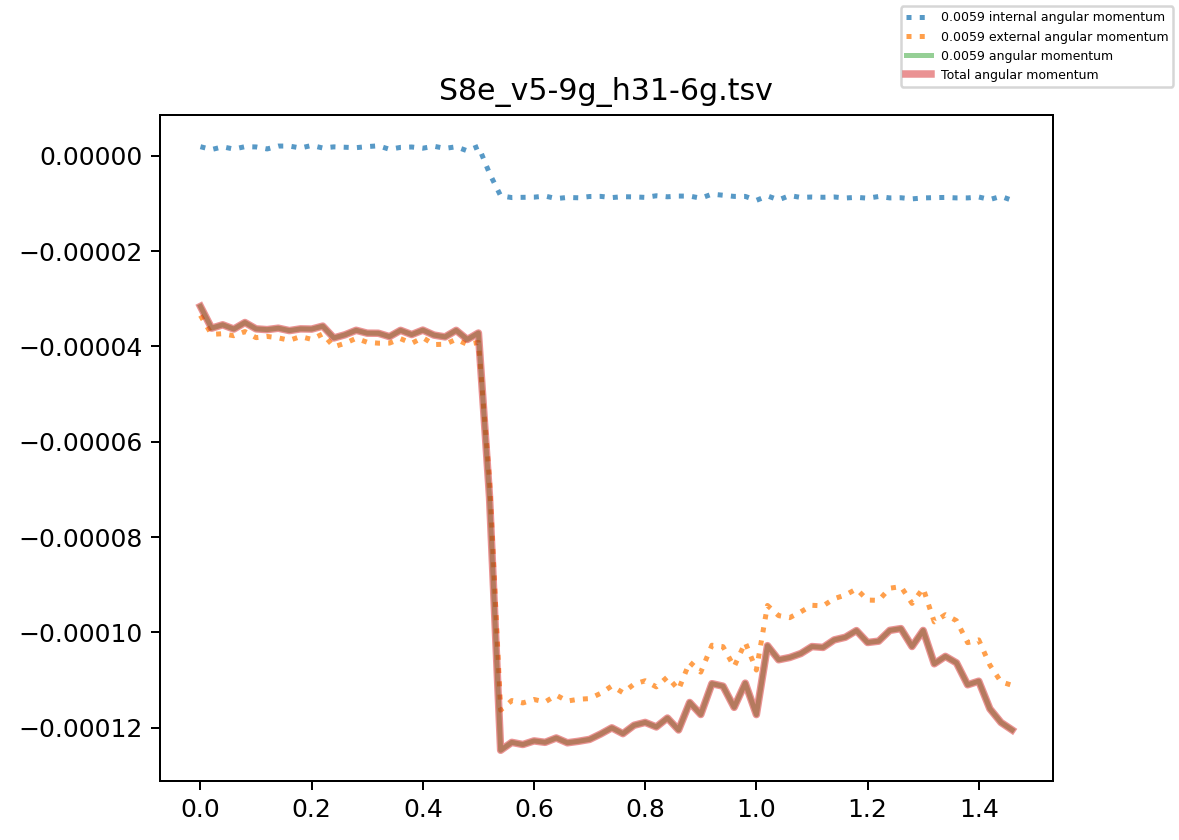

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
from parse_script import parse_marker_data
dir = 'data/S8'

# Precalculated moment of inertias
moment_of_inertia = {"5.9": 3.084225e-6, "14.6": 4.5625e-6, "27.7": 8.65625e-6, "31.6": 0.00001315025, "34.0": 6.8e-6, \
                     "34.3": 6.83e-6, "22.9": 0.0000152542625, "82.2": 0.000038233275, "82.4": 0.0000383263, \
                        "28.3": 0.0000092010375, "43.5": 0.00008632575, "43.3": 0.0000845703125, "396.1": 0.0003083054}

# Generate animations for all tsv files in data folder
for root, dirs, files in os.walk(dir):
    for file in files:
        if file.endswith('.tsv') and file.find('mag') == -1: # Ignore magnitudes data
            print("Generating plot from tsv file: ", file)

            # Parse data
            markers_dict, ts, masses = parse_marker_data(root + '/' + file)
            fig = plt.figure(dpi=180)
            ax = fig.subplots()
            ax.set_title(file)

            # sample step size
            stepsize = 10

            # Set frequency and total time
            frequency = 500/stepsize
            ts0 = np.array(ts[::stepsize][:-1]) - ts[0]

            # Point to calculate angular momentum relative
            point = np.array([0.45,0.45,0])

            # Initialize total angularmomentum, both internal and external
            total_angularmomentum = np.zeros(len(ts0))
            total_external_angularmomentum = np.zeros(len(ts0))

            for name, mass in masses.items():
                # Center of mass
                cm = markers_dict[f"{name}cm"][::stepsize].T * 0.001
                xs, ys, zs = cm
                # Remove z component
                cm = np.array([xs, ys, len(xs)*[0]]).T

                # Rotation point relative center point
                rot = markers_dict[f"{name[0]}x"][::stepsize].T * 0.001 - cm.T
                rxs, rys, rzs = rot
                # Remove z component
                rot = np.array([rxs, rys, len(rxs)*[0]]).T
                rot1 = rot[:-1]
                rot2 = rot[1:]

                # Change in angle
                theta = np.cross(rot1, rot2).T[2]/(np.linalg.norm(rot1, axis=1)*np.linalg.norm(rot2, axis=1))
                
                # Change in velocity
                vs = frequency * (cm[1:] - cm[:-1])

                # Momentum of inertia relative to point
                disc_moi = [moment_of_inertia[f"{name[1:]}"]]*len(vs)
                rs = cm-[point]*len(cm)
                moi =  disc_moi # + mass*np.linalg.norm(rs)**2
                
                # Internal and external angular momentum
                internal_rmm = theta*moi*frequency
                external_rmm = np.cross(rs[1:], mass*vs).T[2]
                
                total_angularmomentum += internal_rmm
                total_external_angularmomentum += external_rmm
                
                ax.plot(ts0, internal_rmm, alpha=0.75, label=f'{mass} internal angular momentum', linewidth=2.0, linestyle=':')
                ax.plot(ts0, external_rmm, alpha=0.75, label=f'{mass} external angular momentum', linewidth=2.0, linestyle=':')
                ax.plot(ts0, internal_rmm + external_rmm, alpha=0.5, label=f'{mass} angular momentum', linewidth=2.0)
            ax.plot(ts0, total_angularmomentum + total_external_angularmomentum, alpha=0.5, label=f'Total angular momentum', linewidth=3.0)
            fig.legend(fontsize=5)
            fig.savefig(f"angularmomentum/{file}.png")